In [1]:
import numpy as np
from dolphin import interferogram, timeseries
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

# Using $L_1$ norm timeseries inversion to preserve unwrapped congruence

In [80]:
np.random.seed(3)

In [82]:
N = 3
days = np.arange(N+1)

ifg_list = interferogram.Network.all_pairs(days)
M = len(ifg_list)
A = timeseries.get_incidence_matrix(ifg_list)

In [83]:
x_true = np.concatenate([[0], np.random.randn(N)])

Text(0, 0.5, 'cycles')

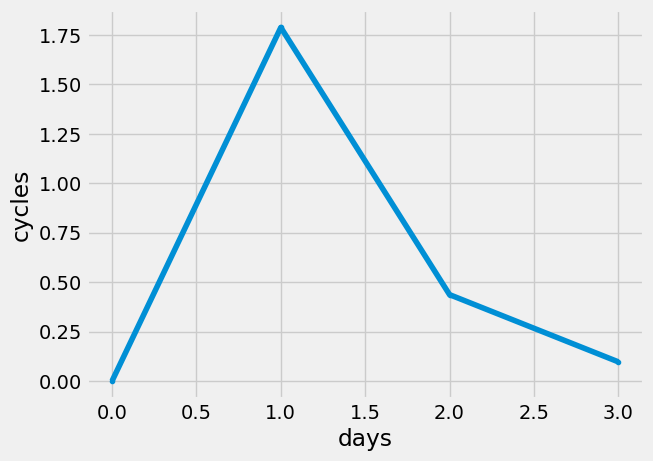

In [84]:
fig, ax = plt.subplots()
ax.plot(days, x_true, '.-')
ax.set_xlabel("days")
ax.set_ylabel("cycles")

In [85]:
def create_noisy_data(A, x_true, pct_errors = 0.1):
    # b_true = np.array([.1, .3, .2, .2, .1, -.1])
    b_true = A @ x_true[1:]
    
    has_unwrapping_error = np.random.random(size=b_true.shape) < pct_errors
    integer_ambiguity_errors = np.random.randint(low=1, high=10, size=b_true.shape)
    k_noise = integer_ambiguity_errors * has_unwrapping_error
    
    b = b_true + k_noise
    assert np.allclose((b - A @ x_true[1:]),  k_noise)
    return b, b_true


In [86]:
b, b_true = create_noisy_data(A, x_true)

In [87]:
print(f"Noise added to differences: {k_noise}")

Noise added to differences: [0 0 0 0 3 0]

Using IRLS, we come up with a sparse residual vector. In this case, it means that we perfectly reconstruct $x$ by ignoring the large single unwrapping error:

In [72]:
x_hat, r0 = timeseries.irls(A, b)
print(f"True x: {x_true.round(3)}")
print(f"Estimate of x: {x_hat.round(3)}")
print(f"Difference: {(x_true[1:] - x_hat).round(2)}")

True x: [0.    1.789 0.437 0.096]

Estimate of x: [1.7880001 0.437     0.097    ]

Difference: [ 0.  0. -0.]

In [73]:
print(f"Residuals: {r0.round(3)}")
print(f"Residuals from the truth:")
print((A@x_hat - b_true).round(3))

Residuals: [0.    0.    0.    0.    2.999 0.   ]

Residuals from the truth:

[-0.    -0.     0.     0.     0.001  0.   ]

If we use least squares to perform the inversion, the errors are smeared out over multiple elements of $x$:

In [66]:
x_l2 = np.linalg.lstsq(A, b, rcond=None)[0]

print(f"Estimate using least squares: {x_l2}")
print(f"Difference: {(x_true[1:] - x_l2).round(2)}")


Estimate using least squares: [1.03862847 0.43650985 0.84649747]

Difference: [ 0.75  0.   -0.75]

## Larger system, more errors

In [101]:
N = 50
days = np.arange(N+1)
ifg_list = interferogram.Network.all_pairs(days)
M = len(ifg_list)
A = timeseries.get_incidence_matrix(ifg_list)

x_true = np.concatenate([[0], np.random.randn(N)])
b, b_true = create_noisy_data(A, x_true, 0.3)

In [102]:
print(b.shape, np.nonzero(b - b_true)[0].shape)

(1275,)
(361,)

In [103]:
x_hat, r0 = timeseries.irls(A, b)
print(f"True x: {x_true.round(3)}")
print(f"Estimate of x: {x_hat.round(3)}")
print(f"Difference: {(x_true[1:] - x_hat).round(2)}")

True x: [ 0.    -0.951 -1.107 -0.074 -3.102  1.177 -0.712 -0.799 -1.164 -0.584
  0.236 -0.345  1.203 -1.608  0.295  1.156 -0.044  1.352 -0.033  1.213
  0.382  2.792  0.104  0.725  0.297  0.607 -0.109  0.695  0.642  1.443
 -1.048 -1.075  0.292  0.372 -1.396 -0.504 -1.045 -1.812 -0.061 -0.52
 -0.919 -0.621  0.606 -0.674 -0.668  0.305  1.649 -0.289  1.36   2.198
  1.172]

Estimate of x: [-0.952      -1.107      -0.074      -3.1020002   1.177      -0.712
 -0.799      -1.164      -0.58400005  0.23600002 -0.34500003  1.2030001
 -1.608       0.29500002  1.156      -0.044       1.3520001  -0.032
  1.2140001   0.38200003  2.792       0.105       0.725       0.298
  0.60700005 -0.109       0.69500005  0.643       1.4440001  -1.0480001
 -1.075       0.29200003  0.372      -1.3950001  -0.504      -1.0450001
 -1.8110001  -0.061      -0.51900005 -0.919      -0.62100005  0.60700005
 -0.67300004 -0.66700006  0.305       1.6500001  -0.289       1.36
  2.1990001   1.1730001 ]

Difference: [ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]

In [104]:
x_l2 = np.linalg.lstsq(A, b, rcond=None)[0]

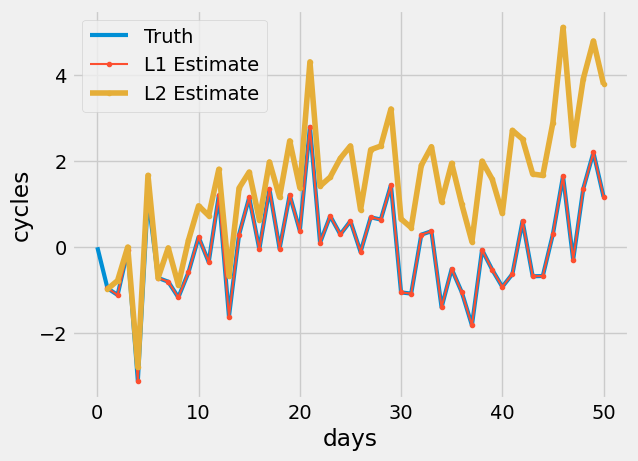

In [108]:
fig, ax = plt.subplots()

ax.plot(days, x_true, '-', label='Truth', lw=3)
ax.plot(days[1:], x_hat, '.-', label='L1 Estimate', lw=1.5)
ax.plot(days[1:], x_l2, '.-', label='L2 Estimate')

ax.set_xlabel("days")
ax.set_ylabel("cycles")
ax.legend()

In [110]:
%%timeit
np.linalg.lstsq(A, b, rcond=None)[0]

5.07 ms ± 492 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [111]:
%%timeit
timeseries.irls(A, b)

26.3 ms ± 686 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
